In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
data =  pd.read_csv("data/FruitflyDataReduced.csv")
data["CompanionNumber"] = data["CompanionNumber"].astype("category", inplace=True)

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()

companion_categories = label_binarizer.fit_transform(data["CompanionNumber"])

data.head()

,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
2,49,Pregnant8,0.68
3,46,Pregnant8,0.72
4,63,Pregnant8,0.72


In [4]:
from theano.tensor import _shared

data_stddev = data["Longevity"].std()
data_mean = data["Longevity"].mean()
indexes = data.CompanionNumber.cat.codes.values
#print("data_stddev: {} data_mean: {} data_length {}".format(data_stddev, data_mean, len(data)))

In [5]:
yMean = data_mean
ySD = data_stddev
print(ySD)
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

17.563892580537072


In [7]:
observations = data["Longevity"]
with pm.Model() as model:
    shape, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
    aSigma = pm.Gamma('aSigma', shape, rate)
    ao = pm.Normal('ao', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal("a", 0.0, tau=1 / (aSigma **2), shape=companion_categories.shape[1])
    
    ySigma = pm.Uniform('ySigma', lower=ySD / 100, upper=ySD * 10)
    
    
    pm.Normal("obs", ao + (a[indexes]), ySigma, observed=observations)
    
    m = pm.Deterministic("m", ao + a)
    bo = pm.Deterministic("bo", tt.mean(m))
    b = pm.Deterministic("b", m - bo)
    
    trace = pm.sample(20000)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ySigma, a, ao, aSigma]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:12<00:00, 567.26draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114eea7b8>,
      dtype=object)

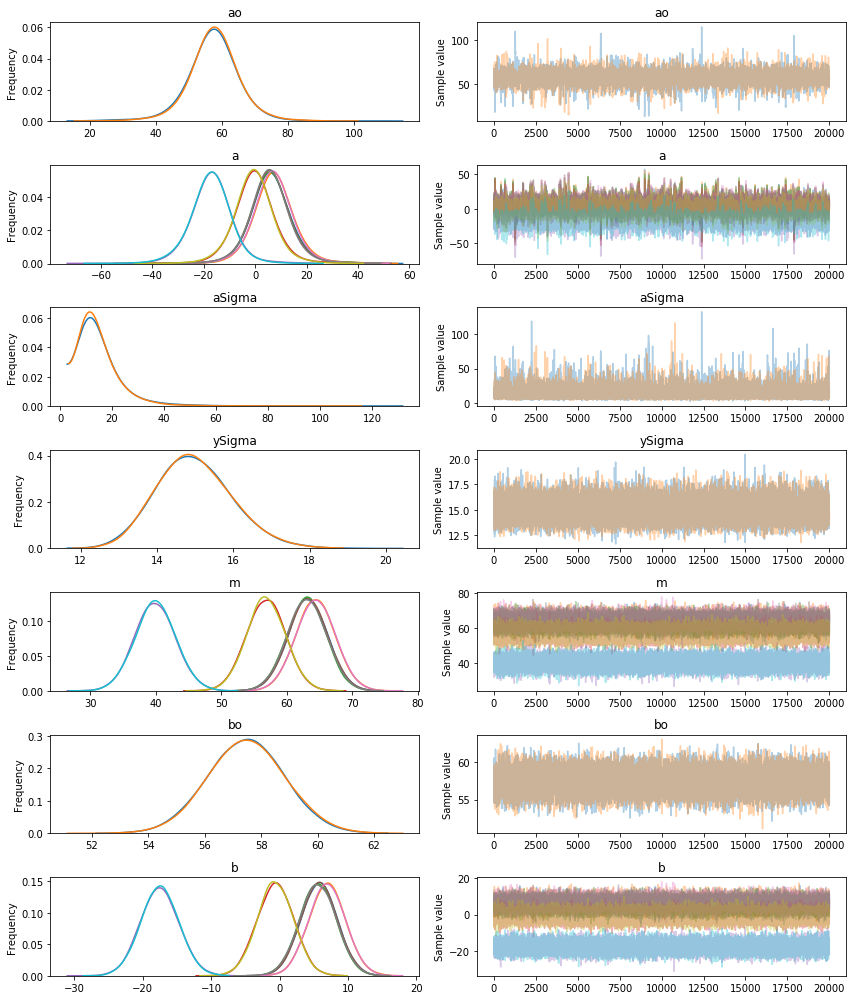

In [8]:
pm.traceplot(trace)

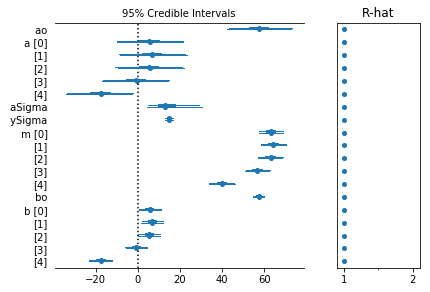

In [9]:
pm.forestplot(trace)

In [10]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ao,57.353092,7.515399,0.092677,43.064190,73.360020,4806.523763,1.000756
a__0,5.843018,7.841555,0.093182,-10.143684,21.103161,5239.403888,1.000662
a__1,7.009988,7.861981,0.092943,-8.870123,22.581864,5194.310531,1.000701
a__2,5.654882,7.858453,0.091744,-9.942860,21.627585,5303.815381,1.000603
a__3,-0.545882,7.855167,0.091768,-16.529165,14.923577,5254.951169,1.000653
a__4,-17.459339,7.868948,0.090934,-33.722294,-2.313537,5412.973563,1.000458
aSigma,14.958891,7.804655,0.087825,5.042341,30.081892,8378.411644,1.000365
ySigma,14.971928,0.982240,0.006619,13.128439,16.953501,22260.920180,0.999994
m__0,63.196110,2.943278,0.011003,57.387405,68.929657,58387.752920,0.999977
m__1,64.363080,2.959535,0.012216,58.345465,69.967674,59044.853236,0.999975


In [11]:
None0 = burned_trace["m"][:,0]
Pregnant1 = burned_trace["m"][:,1]
Pregnant8 = burned_trace["m"][:,2]
Virgin1 = burned_trace["m"][:,3]
Virgin8 = burned_trace["m"][:,4]
scale = burned_trace["ySigma"]

In [12]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        axis.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

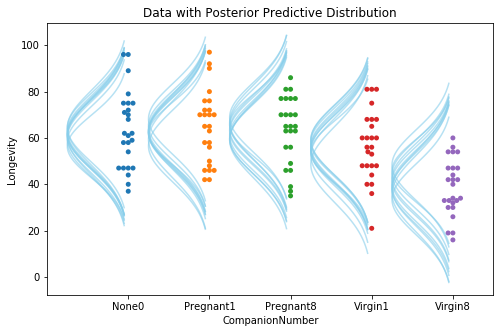

In [13]:
from scipy.stats import norm
color = '#87ceeb'
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=data, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i, ax)

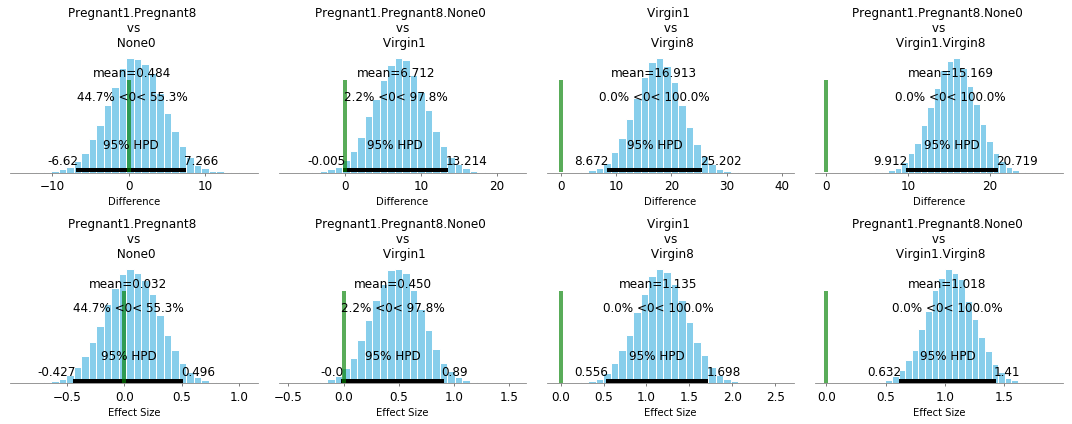

In [14]:
fig, axes = plt.subplots(2,4, figsize=(15,6))
contrasts = [np.mean([Pregnant1, Pregnant8], axis=0)-None0,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1,
             Virgin1-Virgin8,
             np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0)]

contrast_titles = ['Pregnant1.Pregnant8 \n vs \n None0',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1',
                   'Virgin1 \n vs \n Virgin8',
                   'Pregnant1.Pregnant8.None0 \n vs \n Virgin1.Virgin8']

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles, fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr/scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()

In [22]:
thorax_size = data["Thorax"]
mean_thorax = thorax_size.mean()
stddev_thorax = thorax_size.std()
print("mean_thorax {}, sttdev_thorax {}".format(mean_thorax / 2, stddev_thorax*5))

mean_thorax 0.41047999999999996, sttdev_thorax 0.3872683490727694


In [39]:
with pm.Model() as model:
    shape, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
    aSigma = pm.Gamma('aSigma', shape, rate)
    ao = pm.Normal('ao', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal("a", 0.0, tau=1 / (aSigma **2), shape=companion_categories.shape[1])
    covariant = pm.Normal("covariant", tau=1/(2*ySD/stddev_thorax)**2)
    
    ySigma = pm.Uniform('ySigma', lower=ySD / 100, upper=ySD * 10)
    
    
    covar = covariant * (thorax_size - mean_thorax)
    pm.Normal("obs", ao + a[indexes] + covar, ySigma, observed=observations)
    
    bo = pm.Deterministic("bo", ao + tt.mean(a) - covariant*mean_thorax)
    b = pm.Deterministic("b", a - tt.mean(a))
    
    trace2 = pm.sample(20000)
    burned_trace2 = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ySigma, covariant, a, ao, aSigma]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:04<00:00, 328.72draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126dd4080>,
      dtype=object)

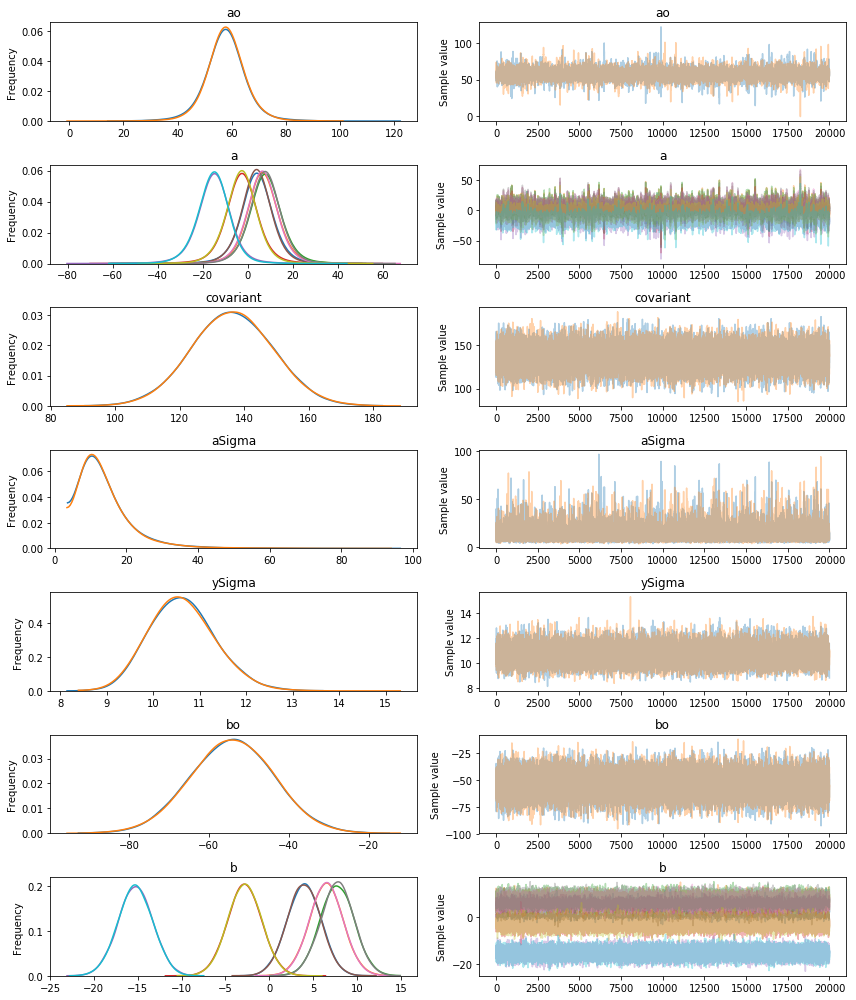

In [40]:
pm.traceplot(trace2)

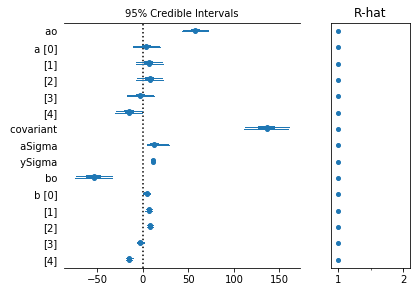

In [41]:
pm.forestplot(trace2)

In [42]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ao,57.511526,6.945588,0.083561,43.232441,71.384877,7271.477297,1.000131
a__0,3.852192,7.132190,0.081517,-10.594866,18.247671,7712.558640,1.000151
a__1,6.391680,7.119413,0.083951,-8.138904,20.496179,7616.614552,1.000119
a__2,7.637819,7.137988,0.083859,-6.824502,21.900617,7638.787435,1.000080
a__3,-2.911752,7.129125,0.082682,-17.310165,11.345561,7720.487677,1.000092
a__4,-15.371737,7.163165,0.083190,-30.322810,-1.556725,7612.671000,1.000161
covariant,136.088260,12.499993,0.083263,111.242921,160.203761,22466.597108,0.999977
aSigma,13.953482,7.419735,0.077273,4.718909,28.075906,10132.263087,1.000005
ySigma,10.619482,0.696108,0.004446,9.338203,12.023646,21238.966556,1.000092
bo,-54.291852,10.307625,0.069183,-74.296454,-33.957987,22476.776620,0.999977


In [38]:
print(mean_thorax.shape)

()


ValueError: Shape of passed values is (7, 38000), indices imply (3, 38000)

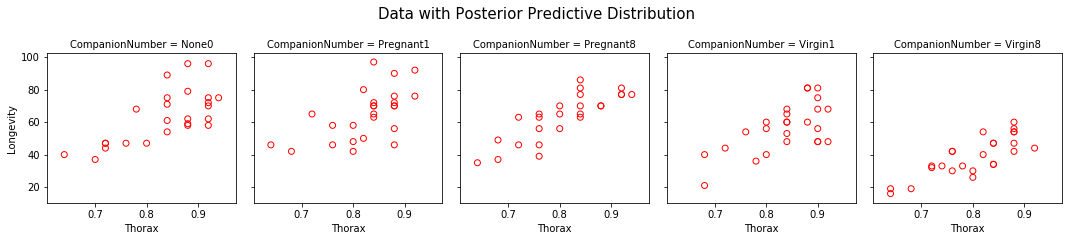

In [37]:
# Here we plot, for every group, the predicted variable and the metric predictor.
# Superimposed are are the posterior predictive distributions.
fg = sns.FacetGrid(data, col='CompanionNumber', despine=False)
fg.map(plt.scatter, 'Thorax', 'Longevity', facecolor='none', edgecolor='r')

plt.suptitle('Data with Posterior Predictive Distribution', y=1.10, fontsize=15)
# Plot credible posterior distribution lines for model in section 19.4
def plot_cred_lines(b0, bj, bcov, x, ax):
   
    B = pd.DataFrame(np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])
    
    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & 
              B.betaj.between(*hpd_interval[1,:]) &
              B.betacov.between(*hpd_interval[2,:])] 
    xrange = np.linspace(x.min()*.95, x.max()*1.05)
   
    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]+B_hpd.iloc[i,2]*xrange, c=color, alpha=.6, zorder=0)  
        
for i, ax in enumerate(fg.axes.flatten()):
    plot_cred_lines(burned_trace2['bo'],
                    burned_trace2['b'],
                    burned_trace2['covariant'],
                    mean_thorax, ax)
    ax.set_xticks(np.arange(.6, 1.1, .1));